In [227]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

In [243]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [244]:
import os
import numpy as np
import shutil
from pathlib import Path

# Directorios donde están actualmente las imágenes
original_dirs = ['/content/drive/MyDrive/Proyecto DL/Positive', '/content/drive/MyDrive/Proyecto DL/Negative']

# Los directorios donde quieres copiar las imágenes
base_dir = '/content/drive/MyDrive/Proyecto DL'
categories = ['positivo', 'negativo']

# Fracciones de imágenes para entrenamiento, validación y prueba
train_frac = 0.7
val_frac = 0.15
test_frac = 0.15

# Número de imágenes a seleccionar
num_images = 2000

for original_dir, category in zip(original_dirs, categories):
    # Lista de todas las imágenes en el directorio original
    images = os.listdir(original_dir)
    np.random.shuffle(images)  # Mezcla las imágenes

    # Selecciona aleatoriamente 2000 imágenes
    images = np.random.choice(images, num_images, replace=False)


    # Calcula el número de imágenes para entrenamiento, validación y prueba
    train_count = int(num_images * train_frac)
    val_count = int(num_images * val_frac)
    test_count = num_images - train_count - val_count  # El resto de las imágenes se usan para la prueba

    # Separa las listas de imágenes
    train_images = images[:train_count]
    val_images = images[train_count:train_count + val_count]
    test_images = images[train_count + val_count:]  # Todas las imágenes restantes después del conjunto de validación

    # Crea los directorios de destino si no existen
    train_dir = os.path.join(base_dir, 'train2', category)
    val_dir = os.path.join(base_dir, 'val2', category)
    test_dir = os.path.join(base_dir, 'test2', category)

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Mueve las imágenes
    for img in train_images:
        shutil.copy(Path(original_dir)/img, Path(train_dir)/img)
    for img in val_images:
        shutil.copy(Path(original_dir)/img, Path(val_dir)/img)
    for img in test_images:
        shutil.copy(Path(original_dir)/img, Path(test_dir)/img)

In [257]:
# Hiperparámetros
batch_size = 32
learning_rate = 0.001
num_epochs = 30

# Transformación para las imágenes: redimensionar, convertir a tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(random.randint(0, 180)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Resize((256, 256))

])

transform2= transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Cargando las imágenes desde las carpetas
train_data = datasets.ImageFolder('/content/drive/MyDrive/Proyecto DL/train2', transform=transform)
valid_data = datasets.ImageFolder('/content/drive/MyDrive/Proyecto DL/val2', transform=transform2)
test_data = datasets.ImageFolder('/content/drive/MyDrive/Proyecto DL/test2', transform=transform2)
# Creando los DataLoaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)


In [285]:
len(train_loader.dataset), len(valid_loader.dataset), len(test_loader.dataset)

(2800, 600, 600)

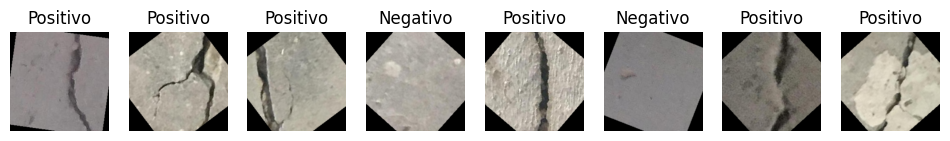

In [282]:
import helper2

# Se muestra el dataset de entrenamiento

train_iter = iter(train_loader)
imagest, labelst = next(train_iter)

fig, axes = plt.subplots(figsize=(12,6), ncols=8)
classes = ["Negativo", "Positivo"]

for ii in range(8):

    ax = axes[ii]
    ax.set_title(classes[labelst[ii].item()])
    helper2.imshow(imagest[ii], ax=ax, normalize=False)

#Red Convolucional Propia

In [265]:
import torch.nn as nn
import torch.nn.functional as F

#Arquitectura
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    # Ingresa objeto imagen 3 canales, 16 mapas de características de salida y kernel 3
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=1)

    # Ingresa objeto tamaño 16 de entrada y 32 de salida
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=1)

    # Ingresa objeto tamaño 32 de entrada y 64 de salida
    self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1)

     #Se reduce imagen a la mitad por medio de maxpooling
    self.pool = nn.MaxPool2d(2, 2)

    #Capa fully connected con entrada 64x32x32 y salida 500
    self.fc1 = nn.Linear(64*32*32, 512)

    #Capa fully connected con entrada 500 y salida 3 (etiquetas)
    self.fc2 = nn.Linear(512, 2)

    #Dropout con probabilidad del 20%
    self.dropout = nn.Dropout(0.2)

  def forward(self, x): #20*3*256*256
    x = self.pool(F.relu(self.conv1(x))) #20*16*128*128
    x = self.pool(F.relu(self.conv2(x))) #20*32*64*64
    x = self.pool(F.relu(self.conv3(x))) #64*32*32
    x = x.view(-1, 64*32*32)
    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

model_propio = CNN()
model_propio

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [283]:
#Se define función de costo y optimizador
import torch.optim as optim

#funcion de costo para clasificación
criterion = nn.CrossEntropyLoss()

#función optimizador Adam y learning rate
optimizer = optim.Adam(model_propio.parameters(), lr=learning_rate)

In [267]:
is_cuda = torch.cuda.is_available()
is_cuda

True

In [268]:
#Entrenamiento
valid_loss_min = np.Inf

if is_cuda:
  model_propio.cuda()

for epoch in range(1, num_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0
    #Entrena el model
    model_propio.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        if is_cuda:
            data, target = data.cuda(), target.cuda()
        #Limpia los gradientes
        optimizer.zero_grad()
        #Calcula la predicción con los datos de entrenamiento
        output = model_propio(data)
        #Calcula las pérdidas
        loss = criterion(output, target)
        #Realiza back propagation y calcula gradientes
        loss.backward()
        #Ejecuta los pasos de optimización
        optimizer.step()
        #Actualiza la perdida de entrenamiento
        train_loss += loss.item()*data.size(0)
        #print('Batch: {}\tTraining Loss: {:.20f}'.format(batch_idx, train_loss))

    #Valida el model
    model_propio.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):

        # Si usa gpu, prepara los datos
        if is_cuda:
            data, target = data.cuda(), target.cuda()
        # Calcula la predicción con los datos de validación
        output = model_propio(data)
        # Calcula el error
        loss = criterion(output, target)
        # Actualiza el error
        valid_loss += loss.item()*data.size(0)
        #print('Batch: {}\tValidation Loss: {:.20f}'.format(batch_idx, valid_loss))

    # Computa los valores de error de entrenamiento y validación

    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    print('Epoch: {}\tTraining Loss: {:.20f}\tValidation Loss: {:.20f}'.format(epoch, train_loss, valid_loss))

    # Guarda el modelo con menor error de validación

    if valid_loss <= valid_loss_min:
      print('Validation loss decreased ({:.20f} --> {:.20f}).  Saving model ...'.format(
      valid_loss_min,
      valid_loss))
      torch.save(model_propio.state_dict(), 'model_proyect.pt')
      valid_loss_min = valid_loss



Epoch: 1	Training Loss: 0.67896962250982006992	Validation Loss: 0.48571128129959106889
Validation loss decreased (inf --> 0.48571128129959106889).  Saving model ...
Epoch: 2	Training Loss: 0.36965140768459864296	Validation Loss: 0.31814443429311117795
Validation loss decreased (0.48571128129959106889 --> 0.31814443429311117795).  Saving model ...
Epoch: 3	Training Loss: 0.21173271453806333242	Validation Loss: 0.16057351360718408184
Validation loss decreased (0.31814443429311117795 --> 0.16057351360718408184).  Saving model ...
Epoch: 4	Training Loss: 0.14595149248838423794	Validation Loss: 0.10194663872321446663
Validation loss decreased (0.16057351360718408184 --> 0.10194663872321446663).  Saving model ...
Epoch: 5	Training Loss: 0.11485055246523448447	Validation Loss: 0.09658792654673258038
Validation loss decreased (0.10194663872321446663 --> 0.09658792654673258038).  Saving model ...
Epoch: 6	Training Loss: 0.08547303569103990861	Validation Loss: 0.08060561552643775995
Validation l

In [269]:
#Ejecuta el guardado del modelo
model_propio.load_state_dict(torch.load('model_proyect.pt'))

<All keys matched successfully>

In [271]:
# Evaluación del modelo con datos de prueba
model_propio.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        if is_cuda:
          images, labels = images.cuda(), labels.cuda()
        outputs = model_propio(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Precisión del modelo en las imágenes de test: {}%'.format(100 * correct / total))

Precisión del modelo en las imágenes de prueba: 98.33333333333333%


In [ ]:
#Mostrar imágenes incorrectamente clasificadas

model_propio.eval()

with torch.no_grad():
    all_labels = []
    all_predictions = []
    incorrect_images = []
    incorrect_labels = []
    incorrect_predictions = []
    for i, (images, labels) in enumerate(test_loader):
        if is_cuda:
            images, labels = images.cuda(), labels.cuda()
        outputs = model_propio(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        # Buscar imágenes incorrectas
        incorrect_inds = (predicted != labels).nonzero().squeeze(-1)  # índices de predicciones incorrectas
        incorrect_images.extend(images[incorrect_inds].cpu().numpy())  # imágenes incorrectas
        incorrect_labels.extend(labels[incorrect_inds].cpu().numpy())  # etiquetas reales de imágenes incorrectas
        incorrect_predictions.extend(predicted[incorrect_inds].cpu().numpy())  # predicciones incorrectas

# Convertir las listas de labels y predicciones en arrays numpy
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
incorrect_images = np.array(incorrect_images)
incorrect_labels = np.array(incorrect_labels)
incorrect_predictions = np.array(incorrect_predictions)

# Imprimir imágenes incorrectas
print('Imágenes incorrectamente clasificadas:')
for img, correct_label, incorrect_label in zip(incorrect_images, incorrect_labels, incorrect_predictions):
    plt.figure()
    plt.imshow(np.transpose(img, (1, 2, 0)))  # asumiendo que tus imágenes son RGB
    plt.title(f"Correct label: {correct_label}, Predicted label: {incorrect_label}")
    plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Calcular la matriz de confusión
conf_matrix = confusion_matrix(all_labels, all_predictions)
print('Matriz de confusión:')
print(conf_matrix)

plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [277]:
!pip install duckduckgo_search
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.7 MB/s eta 0:00:00


In [278]:
urls = search_images('concrete cracks', max_images=5)
urls

Searching for 'concrete cracks'


/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


(#5) ['http://johnnysconcrete.ca/wp-content/uploads/2015/10/johnnys-concrete-warrant-breaks-e1445279047846.jpg','https://storage.googleapis.com/webdesignledger.pub.network/LaT/edd/2016/02/cracked-concrete-texture-1.jpg','https://www.devooghthouselifters.com/wp-content/uploads/2019/11/crack-floor-scaled.jpeg','https://www.easymixconcrete.com/wp-content/uploads/2020/12/concrete-cracking.jpg','https://storage.googleapis.com/webdesignledger.pub.network/LaT/edd/2016/02/cracked-concrete-texture-9.jpg']

In [ ]:
from fastdownload import download_url
dest = 'motorbike.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)+


In [ ]:
download_url(search_images('bicycle photos', max_images=1)[0], 'bicycle.jpg', show_progress=False)
Image.open('bicycle.jpg').to_thumb(256,256)

In [ ]:
searches = 'motorbike','bicycle'
path = Path('motorbike_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

##MODELO RESNET

In [284]:
#Entrenamiento del modelo resnet

is_cuda = torch.cuda.is_available()

model_resnet = models.resnet50(pretrained=True)

# Cambiando la última capa para adaptarse a la salida de dos categorías.
model_resnet.fc = nn.Linear(2048, 2)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.parameters(), lr=learning_rate)

if is_cuda:
  model_resnet.cuda()

# Entrenamiento del modelo
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        if is_cuda:

            images, labels = images.cuda(), labels.cuda()
        # Propagación hacia adelante
        outputs = model_resnet(images)
        loss = criterion(outputs, labels)

        # Propagación hacia atrás y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        progress = 100. * (i + epoch * len(train_loader)) / (num_epochs * len(train_loader)) # Actualizar la barra de progreso
        tqdm.write(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}, Progress: {progress:.2f}%')



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 227MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomRes

Epoch [1/30], Step [1/88], Loss: 0.7682, Progress: 0.00%
Epoch [1/30], Step [2/88], Loss: 0.4250, Progress: 0.04%
Epoch [1/30], Step [3/88], Loss: 1.3098, Progress: 0.08%
Epoch [1/30], Step [4/88], Loss: 0.9479, Progress: 0.11%
Epoch [1/30], Step [5/88], Loss: 0.3682, Progress: 0.15%
Epoch [1/30], Step [6/88], Loss: 0.1231, Progress: 0.19%
Epoch [1/30], Step [7/88], Loss: 0.0443, Progress: 0.23%
Epoch [1/30], Step [8/88], Loss: 0.1078, Progress: 0.27%
Epoch [1/30], Step [9/88], Loss: 0.0425, Progress: 0.30%
Epoch [1/30], Step [10/88], Loss: 0.0142, Progress: 0.34%
Epoch [1/30], Step [11/88], Loss: 0.0113, Progress: 0.38%
Epoch [1/30], Step [12/88], Loss: 0.0221, Progress: 0.42%
Epoch [1/30], Step [13/88], Loss: 0.0636, Progress: 0.45%
Epoch [1/30], Step [14/88], Loss: 0.0158, Progress: 0.49%
Epoch [1/30], Step [15/88], Loss: 0.0188, Progress: 0.53%
Epoch [1/30], Step [16/88], Loss: 0.0264, Progress: 0.57%
Epoch [1/30], Step [17/88], Loss: 0.0123, Progress: 0.61%
Epoch [1/30], Step [18/

In [287]:
# Validación del modelo
model_resnet.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in valid_loader:
        if is_cuda:

            images, labels = images.cuda(), labels.cuda()
        outputs = model_resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Precisión del modelo en las imágenes de validación: {}%'.format(100 * correct / total))

Precisión del modelo en las imágenes de validación: 99.66666666666667%


In [288]:
# Evaluación del modelo con datos de test
model_resnet.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        if is_cuda:

            images, labels = images.cuda(), labels.cuda()
        outputs = model_resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Precisión del modelo en las imágenes de test: {}%'.format(100 * correct / total))

Precisión del modelo en las imágenes de test: 99.66666666666667%


Matriz de confusión:
[[299   1]
 [  1 299]]
Imágenes incorrectamente clasificadas:


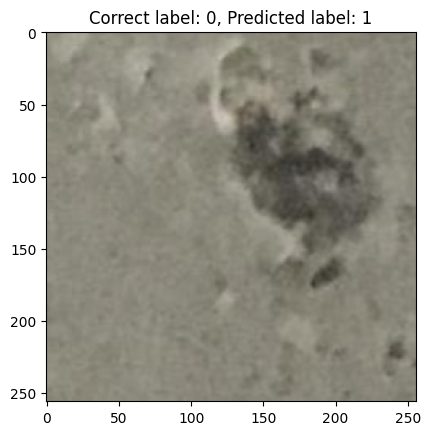

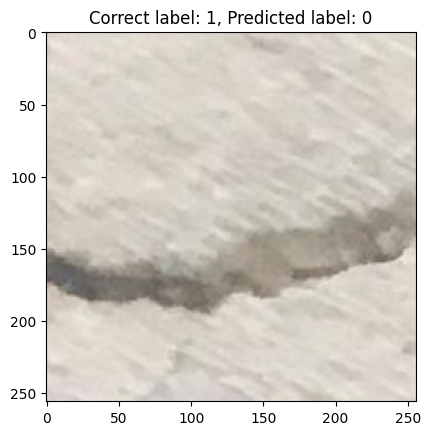

In [289]:
#Mostrar imágenes incorrectamente clasificadas

model_resnet.eval()
with torch.no_grad():
    all_labels = []
    all_predictions = []
    incorrect_images = []
    incorrect_labels = []
    incorrect_predictions = []
    for i, (images, labels) in enumerate(test_loader):
        if is_cuda:
            images, labels = images.cuda(), labels.cuda()
        outputs = model_resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        # Buscar imágenes incorrectas
        incorrect_inds = (predicted != labels).nonzero().squeeze(-1)  # índices de predicciones incorrectas
        incorrect_images.extend(images[incorrect_inds].cpu().numpy())  # imágenes incorrectas
        incorrect_labels.extend(labels[incorrect_inds].cpu().numpy())  # etiquetas reales de imágenes incorrectas
        incorrect_predictions.extend(predicted[incorrect_inds].cpu().numpy())  # predicciones incorrectas

# Convertir las listas de labels y predicciones en arrays numpy
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
incorrect_images = np.array(incorrect_images)
incorrect_labels = np.array(incorrect_labels)
incorrect_predictions = np.array(incorrect_predictions)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(all_labels, all_predictions)
print('Matriz de confusión:')
print(conf_matrix)

# Imprimir imágenes incorrectas
print('Imágenes incorrectamente clasificadas:')
for img, correct_label, incorrect_label in zip(incorrect_images, incorrect_labels, incorrect_predictions):
    plt.figure()
    plt.imshow(np.transpose(img, (1, 2, 0)))  # asumiendo que tus imágenes son RGB
    plt.title(f"Correct label: {correct_label}, Predicted label: {incorrect_label}")
    plt.show()

## Densenet

In [286]:
#Entrenamiento del modelo densenet

is_cuda = torch.cuda.is_available()

model_densenet = models.densenet121(pretrained=True)

model_densenet.classifier = nn.Linear(1024, 2)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_densenet.parameters(), lr=learning_rate)

if is_cuda:

  model_densenet.cuda()

# Entrenamiento del modelo
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        if is_cuda:

            images, labels = images.cuda(), labels.cuda()
        # Propagación hacia adelante
        outputs = model_densenet(images)
        loss = criterion(outputs, labels)

        # Propagación hacia atrás y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        progress = 100. * (i + epoch * len(train_loader)) / (num_epochs * len(train_loader)) # Actualizar la barra de progreso
        tqdm.write(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}, Progress: {progress:.2f}%')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 179MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(

Epoch [1/30], Step [1/88], Loss: 0.6304, Progress: 0.00%
Epoch [1/30], Step [2/88], Loss: 0.1101, Progress: 0.04%
Epoch [1/30], Step [3/88], Loss: 0.1667, Progress: 0.08%
Epoch [1/30], Step [4/88], Loss: 0.0483, Progress: 0.11%
Epoch [1/30], Step [5/88], Loss: 0.0184, Progress: 0.15%
Epoch [1/30], Step [6/88], Loss: 0.0260, Progress: 0.19%
Epoch [1/30], Step [7/88], Loss: 0.1460, Progress: 0.23%
Epoch [1/30], Step [8/88], Loss: 0.0018, Progress: 0.27%
Epoch [1/30], Step [9/88], Loss: 0.0867, Progress: 0.30%
Epoch [1/30], Step [10/88], Loss: 0.0723, Progress: 0.34%
Epoch [1/30], Step [11/88], Loss: 0.0953, Progress: 0.38%
Epoch [1/30], Step [12/88], Loss: 0.0442, Progress: 0.42%
Epoch [1/30], Step [13/88], Loss: 0.0686, Progress: 0.45%
Epoch [1/30], Step [14/88], Loss: 0.0047, Progress: 0.49%
Epoch [1/30], Step [15/88], Loss: 0.3783, Progress: 0.53%
Epoch [1/30], Step [16/88], Loss: 0.0068, Progress: 0.57%
Epoch [1/30], Step [17/88], Loss: 0.0788, Progress: 0.61%
Epoch [1/30], Step [18/

In [290]:
# Validación del modelo densenet
model_densenet.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in valid_loader:
        if is_cuda:
            images, labels = images.cuda(), labels.cuda()
        outputs = model_densenet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Precisión del modelo en las imágenes de validación: {}%'.format(100 * correct / total))

Precisión del modelo en las imágenes de validación: 98.83333333333333%


In [291]:
# Evaluación del modelo con datos de test
model_densenet.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        if is_cuda:
            images, labels = images.cuda(), labels.cuda()
        outputs = model_densenet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Precisión del modelo en las imágenes de test: {}%'.format(100 * correct / total))

Precisión del modelo en las imágenes de test: 99.33333333333333%


Matriz de confusión:
[[300   0]
 [  4 296]]
Imágenes incorrectamente clasificadas:


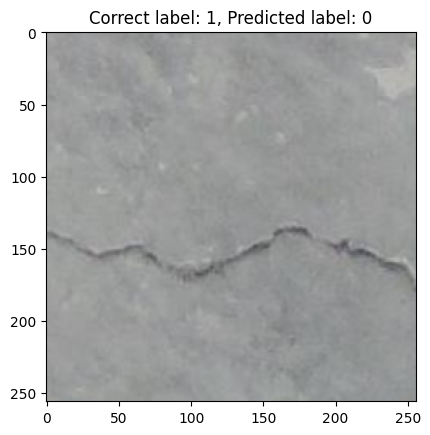

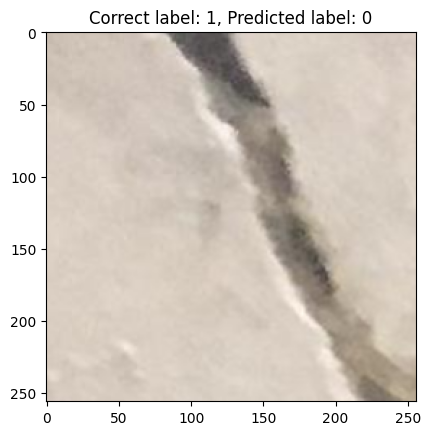

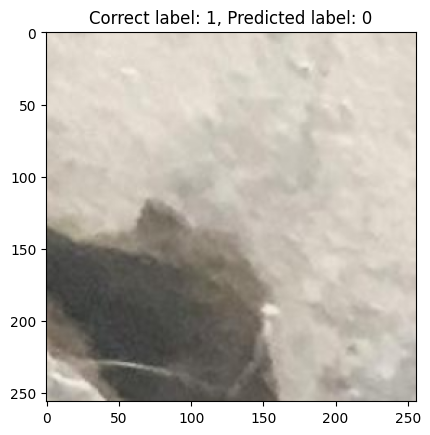

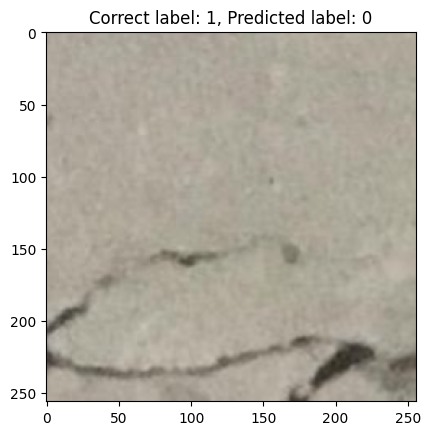

In [292]:
#Mostrar imágenes incorrectamente clasificadas

model_densenet.eval()

with torch.no_grad():
    all_labels = []
    all_predictions = []
    incorrect_images = []
    incorrect_labels = []
    incorrect_predictions = []
    for i, (images, labels) in enumerate(test_loader):
        if is_cuda:
            images, labels = images.cuda(), labels.cuda()
        outputs = model_densenet(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        # Buscar imágenes incorrectas
        incorrect_inds = (predicted != labels).nonzero().squeeze(-1)  # índices de predicciones incorrectas
        incorrect_images.extend(images[incorrect_inds].cpu().numpy())  # imágenes incorrectas
        incorrect_labels.extend(labels[incorrect_inds].cpu().numpy())  # etiquetas reales de imágenes incorrectas
        incorrect_predictions.extend(predicted[incorrect_inds].cpu().numpy())  # predicciones incorrectas

# Convertir las listas de labels y predicciones en arrays numpy
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
incorrect_images = np.array(incorrect_images)
incorrect_labels = np.array(incorrect_labels)
incorrect_predictions = np.array(incorrect_predictions)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(all_labels, all_predictions)
print('Matriz de confusión:')
print(conf_matrix)

# Imprimir imágenes incorrectas
print('Imágenes incorrectamente clasificadas:')
for img, correct_label, incorrect_label in zip(incorrect_images, incorrect_labels, incorrect_predictions):
    plt.figure()
    plt.imshow(np.transpose(img, (1, 2, 0)))  # asumiendo que tus imágenes son RGB
    plt.title(f"Correct label: {correct_label}, Predicted label: {incorrect_label}")
    plt.show()
